# **Back-end**



---





This notebook will produce the Data needed to plot in the first version of the Back-End.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Importing all the required packages

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import sklearn

from scipy.stats import norm
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler, StandardScaler
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

%matplotlib inline

In [ ]:
data_rnec = pd.read_csv('/content/drive/My Drive/DS4A_DB/rnec_v2.csv', encoding='latin1',sep=';')
data_rnec.head(5)

,id_data,fecha_recepcion,id_macroproceso,id_estado_radicado,id_unidad_administrativa,id_anotacion,id_departamento_rnec,id_traslado,id_departamento,id_estado_pqrs,fecha_cierre,dias,dias_laborales,id_fuente_general,id_medio,id_canal,id_municipio,id_nivel,id_oportunidad_cierre,id_oportunidad_tratamiento,cod_iso3,id_sexo,id_tipo_solicitud,id_tipo_identificacion,asunto,Reception_month
0,1,10/01/2019,3,2,2,0,91,0,91,3,14/01/2019,4,3,1,5,2,0,1,1,2,COL,0,1,3,P. - I.D. - T.I. - Agendamiento,1
1,2,22/01/2019,3,2,2,0,91,0,91,3,25/01/2019,3,4,1,5,2,0,1,1,2,COL,0,1,1,P. - I.D. - C.C. - Traslado.,1
2,3,23/01/2019,3,2,2,0,91,481,91,3,25/01/2019,2,3,1,5,2,0,1,1,2,COL,0,9,1,P. - I.D. - C.C. - Cancelaciones.,1
3,4,25/01/2019,4,2,2,0,91,0,91,3,30/01/2019,5,4,1,5,2,0,1,1,2,COL,0,6,1,Q. -Por atencion irrespetuosa del servidor pub...,1
4,5,25/01/2019,4,2,2,0,91,0,91,3,30/01/2019,5,4,1,5,2,0,1,1,2,COL,0,6,1,Q. -Por atencion irrespetuosa del servidor pub...,1


## Removing data with no closed date.

In [ ]:

data_rnec_aux=data_rnec[data_rnec['fecha_cierre']!='30/01/2020']
data_rnec_aux.shape

(201918, 26)

In [ ]:
data_rnec.shape

(217675, 26)

#**Exploratory Data Analysis (EDA)**






Now we are going to change some values which are errors to the value: ""

In [ ]:
#data_rnec['fec_defin_cierre']=data_rnec['fec_defin_cierre'].replace(['PeticiÃ³n Abierta','Sin fecha de cierre','En trÃ¡mite de respuesta', 'Dato no reportado','Inconsistencia','En trÃ¡mite de respuesta','En trÃ¡mite de respuesta '], '')
#data_rnec['fec_defin_cierre']=data_rnec['fec_defin_cierre'].replace(['Petición Abierta','En trámite de respuesta','En trámite de respuesta ',''],'')

In [ ]:
#data_rnec['fecha_cierre'].unique()

Now is the time to compute the time of service for the pqrs

In [ ]:
data_rnec_aux['Service_time_days']=data_rnec['dias']
data_rnec_aux.head(5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,id_data,fecha_recepcion,id_macroproceso,id_estado_radicado,id_unidad_administrativa,id_anotacion,id_departamento_rnec,id_traslado,id_departamento,id_estado_pqrs,fecha_cierre,dias,dias_laborales,id_fuente_general,id_medio,id_canal,id_municipio,id_nivel,id_oportunidad_cierre,id_oportunidad_tratamiento,cod_iso3,id_sexo,id_tipo_solicitud,id_tipo_identificacion,asunto,Reception_month,Service_time_days
0,1,10/01/2019,3,2,2,0,91,0,91,3,14/01/2019,4,3,1,5,2,0,1,1,2,COL,0,1,3,P. - I.D. - T.I. - Agendamiento,1,4
1,2,22/01/2019,3,2,2,0,91,0,91,3,25/01/2019,3,4,1,5,2,0,1,1,2,COL,0,1,1,P. - I.D. - C.C. - Traslado.,1,3
2,3,23/01/2019,3,2,2,0,91,481,91,3,25/01/2019,2,3,1,5,2,0,1,1,2,COL,0,9,1,P. - I.D. - C.C. - Cancelaciones.,1,2
3,4,25/01/2019,4,2,2,0,91,0,91,3,30/01/2019,5,4,1,5,2,0,1,1,2,COL,0,6,1,Q. -Por atencion irrespetuosa del servidor pub...,1,5
4,5,25/01/2019,4,2,2,0,91,0,91,3,30/01/2019,5,4,1,5,2,0,1,1,2,COL,0,6,1,Q. -Por atencion irrespetuosa del servidor pub...,1,5


There are some values which are negative, that has no sense for our analysis in this stage so we will only consider the times greater 0

In [ ]:
df_servicio=data_rnec_aux[data_rnec_aux['Service_time_days']>=0]
#df_servicio['fecha_recepcion']= pd.to_datetime(df_servicio['fecha_recepcion'])
#df_servicio['Reception_month']=df_servicio['fecha_recepcion'].dt.month
df_servicio.head()

,id_data,fecha_recepcion,id_macroproceso,id_estado_radicado,id_unidad_administrativa,id_anotacion,id_departamento_rnec,id_traslado,id_departamento,id_estado_pqrs,fecha_cierre,dias,dias_laborales,id_fuente_general,id_medio,id_canal,id_municipio,id_nivel,id_oportunidad_cierre,id_oportunidad_tratamiento,cod_iso3,id_sexo,id_tipo_solicitud,id_tipo_identificacion,asunto,Reception_month,Service_time_days
0,1,10/01/2019,3,2,2,0,91,0,91,3,14/01/2019,4,3,1,5,2,0,1,1,2,COL,0,1,3,P. - I.D. - T.I. - Agendamiento,1,4
1,2,22/01/2019,3,2,2,0,91,0,91,3,25/01/2019,3,4,1,5,2,0,1,1,2,COL,0,1,1,P. - I.D. - C.C. - Traslado.,1,3
2,3,23/01/2019,3,2,2,0,91,481,91,3,25/01/2019,2,3,1,5,2,0,1,1,2,COL,0,9,1,P. - I.D. - C.C. - Cancelaciones.,1,2
3,4,25/01/2019,4,2,2,0,91,0,91,3,30/01/2019,5,4,1,5,2,0,1,1,2,COL,0,6,1,Q. -Por atencion irrespetuosa del servidor pub...,1,5
4,5,25/01/2019,4,2,2,0,91,0,91,3,30/01/2019,5,4,1,5,2,0,1,1,2,COL,0,6,1,Q. -Por atencion irrespetuosa del servidor pub...,1,5


In [ ]:
df_servicio.shape

(201703, 27)

# <h2>1. Distribution of Service Time  </h2>

## Creating distributions for the service of time for the different moths

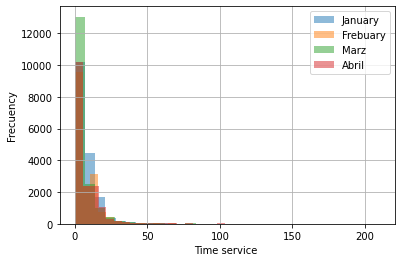

In [ ]:
df_servicio['Service_time_days'][df_servicio.Reception_month == 1].hist(bins=30, alpha=0.5, label="January")
df_servicio['Service_time_days'][df_servicio.Reception_month == 2].hist(bins=30, alpha=0.5, label="Frebuary")
df_servicio['Service_time_days'][df_servicio.Reception_month == 3].hist(bins=30, alpha=0.5, label="Marz")
df_servicio['Service_time_days'][df_servicio.Reception_month == 4].hist(bins=30, alpha=0.5, label="Abril")
plt.xlabel("Time service ")
plt.ylabel("Frecuency")
plt.legend()

## Creating distributions for the service of time for the most common channels of reception

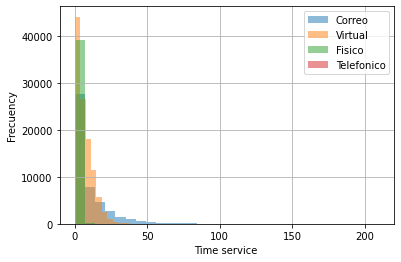

In [ ]:
df_servicio['Service_time_days'][df_servicio.id_canal == 1].hist(bins=30, alpha=0.5, label="Correo")
df_servicio['Service_time_days'][df_servicio.id_canal == 2].hist(bins=30, alpha=0.5, label="Virtual")
df_servicio['Service_time_days'][df_servicio.id_canal == 3].hist(bins=30, alpha=0.5, label="Fisico")
df_servicio['Service_time_days'][df_servicio.id_canal == 4].hist(bins=30, alpha=0.5, label="Telefonico")
plt.xlabel("Time service ")
plt.ylabel("Frecuency")
plt.legend()

# <h2>2. Average of Service Time by Reception month of requests </h2>

We want to look how long is the average of the consumed time for the different months of the year in order to see if there is any trend on the time the RNEC spends every month

In [ ]:
total_rows = df_servicio['Reception_month'].count()
total_rows

201703

In [ ]:
total_rows = df_servicio['Reception_month'].count()
df_serv_mes=df_servicio.groupby(['Reception_month']).agg({'Service_time_days':'mean'}).rename(columns={'Service_time_days':'Average of service time (days)'})
df_serv_mes_count=df_servicio.groupby(['Reception_month']).agg({'Service_time_days':'count'}).rename(columns={'Service_time_days':'Total_requests'})
df_serv_mes['Total_requests'] = df_serv_mes_count['Total_requests']
df_serv_mes['Proportion']=((df_serv_mes_count['Total_requests']/total_rows)*100).round(2)
df_serv_mes


,Average of service time (days),Total_requests,Proportion
Reception_month,,,
1,6.727669,17185,8.52
2,7.039679,16810,8.33
3,5.154926,17460,8.66
4,6.969874,16962,8.41
5,5.836178,21206,10.51
6,6.471196,18869,9.35
7,6.581865,25420,12.60
8,5.290664,21530,10.67
9,2.968883,19700,9.77


<h2>3. Average of service time by type of request</h2>

From the picture above we can conclude that the amount of requests and the time to solve the request are correlated.

In [ ]:
df_serv_soli=df_servicio.groupby(['id_tipo_solicitud']).agg({'Service_time_days':'mean'}).rename(columns={'Service_time_days':'Average of service time (days)'})
df_serv_soli_count=df_servicio.groupby(['id_tipo_solicitud']).agg({'Service_time_days':'count'}).rename(columns={'Service_time_days':'Total_requests'})
df_serv_soli['Total_requests'] = df_serv_soli_count['Total_requests']
df_serv_soli['Proportion']=((df_serv_soli['Total_requests']/total_rows)*100).round(2)
df_serv_soli.index.rename('Type of request', inplace=True)
df_serv_soli

,Average of service time (days),Total_requests,Proportion
Type of request,,,
0,4.098648,18419,9.13
1,6.908632,49919,24.75
2,7.021318,11868,5.88
3,6.757661,12466,6.18
5,5.398230,226,0.11
6,6.116700,2982,1.48
7,5.453815,249,0.12
8,5.130445,4132,2.05
9,5.272274,101442,50.29


<h2>4. Average of service time by channel </h2>

In [ ]:
df_serv_canal=df_servicio.groupby(['id_canal']).agg({'Service_time_days':'mean'}).rename(columns={'Service_time_days':'Average of service time (days)'})
df_serv_canal_count=df_servicio.groupby(['id_canal']).agg({'Service_time_days':'count'}).rename(columns={'Service_time_days':'Total_requests'})
df_serv_canal['Total_requests'] = df_serv_canal_count['Total_requests']
df_serv_canal['Proportion']=((df_serv_canal['Total_requests']/total_rows)*100).round(2)
df_serv_canal.index.rename('Type of Channel', inplace=True)
df_serv_canal

,Average of service time (days),Total_requests,Proportion
Type of Channel,,,
0,13.000000,1,0.00
1,9.662267,47126,23.36
2,6.421874,110168,54.62
3,0.048023,39294,19.48
4,0.010364,5114,2.54


<h2>5. Average of service time by Macro-processes </h2>

In [ ]:
df_serv_macrop=df_servicio.groupby(['id_macroproceso']).agg({'Service_time_days':'mean'}).rename(columns={'Service_time_days':'Average of service time (days)'})
df_serv_macrop_count=df_servicio.groupby(['id_macroproceso']).agg({'Service_time_days':'count'}).rename(columns={'Service_time_days':'Total_requests'})
df_serv_macrop['Total_requests'] = df_serv_macrop_count['Total_requests']
df_serv_macrop['Proportion']=((df_serv_macrop['Total_requests']/total_rows)*100).round(2)
df_serv_macrop.index.rename('Type of Macroprocess', inplace=True)
df_serv_macrop

,Average of service time (days),Total_requests,Proportion
Type of Macroprocess,,,
0,7.089320,1030,0.51
1,6.342657,143,0.07
2,6.265060,83,0.04
3,5.711380,163443,81.03
4,6.120171,29666,14.71
5,5.000000,1365,0.68
6,7.066991,821,0.41
7,5.705866,3495,1.73
8,4.856187,1196,0.59


<h2>6. Barplots about different features </h2>

## We want to look closely to the amount of requests for  each of the features

[Text(0, 0.5, 'Total of request'), Text(0.5, 0, 'Type of Macroprocess')]

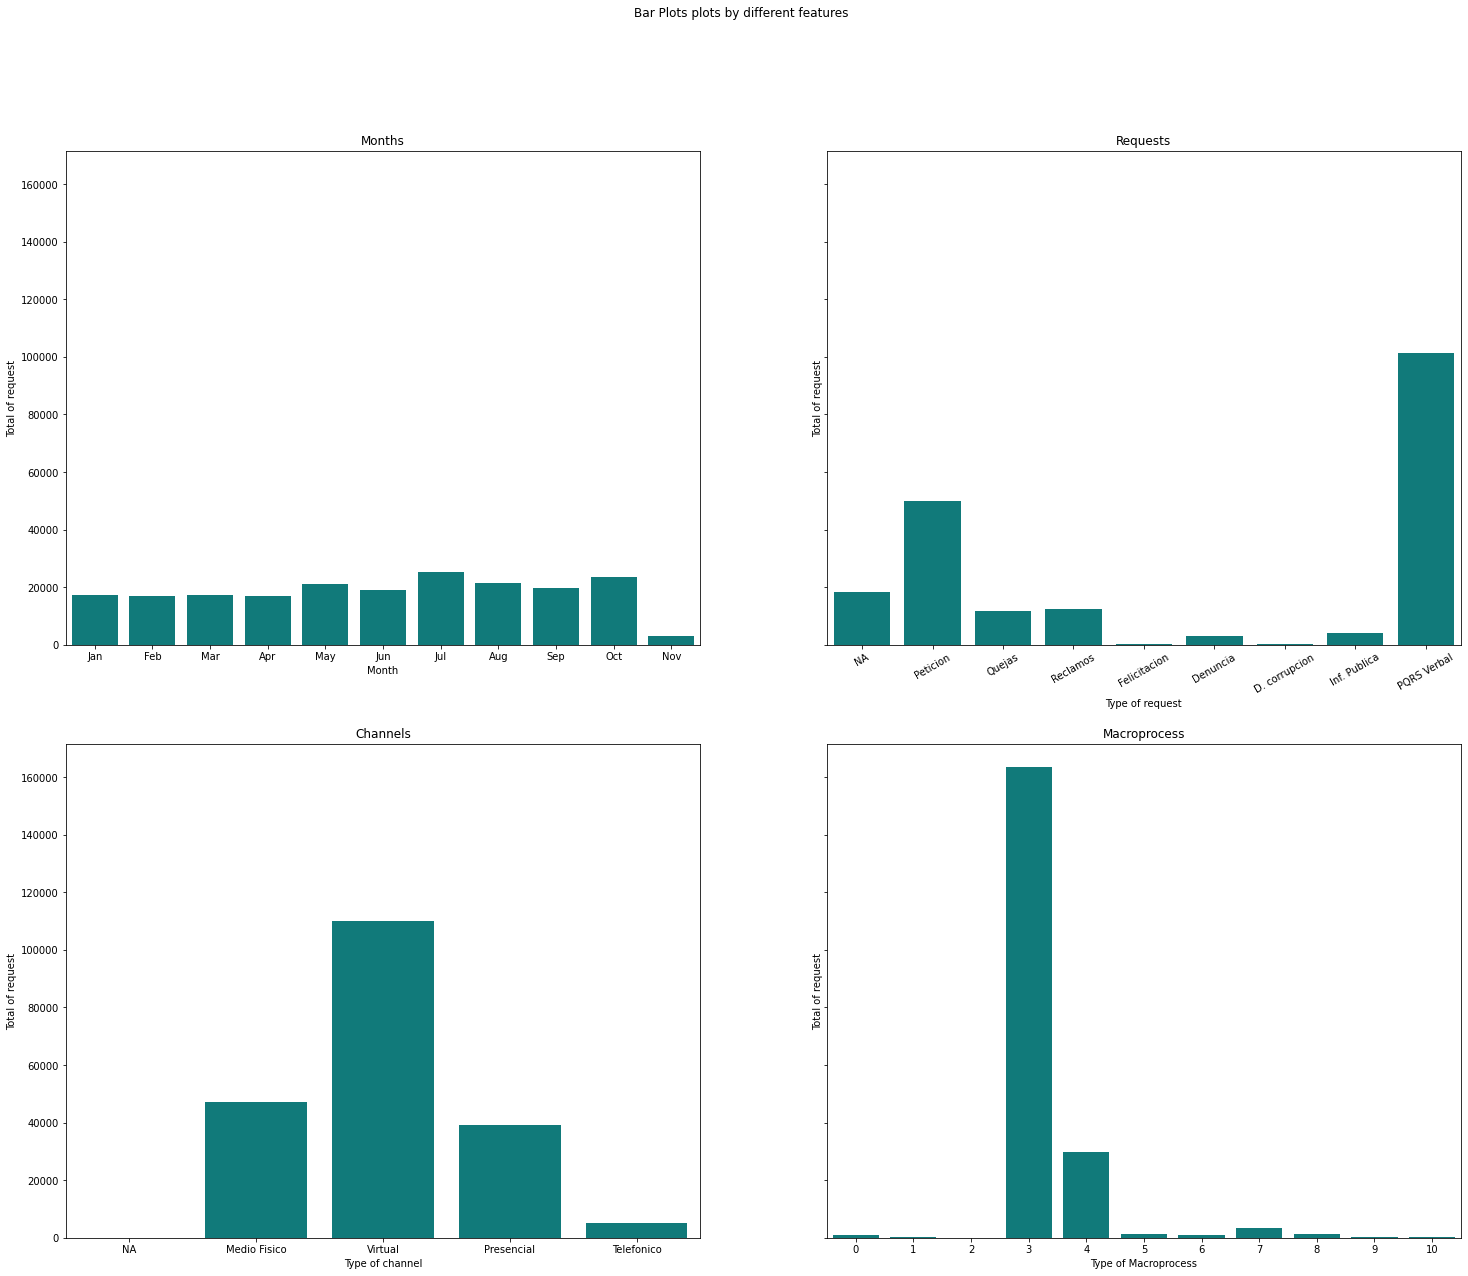

In [ ]:
fig, axs = plt.subplots(ncols = 2, nrows=2,  sharey=True, figsize=(25,20))
fig.suptitle('Bar Plots plots by different features')
months=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov']
request=['NA','Peticion','Quejas','Reclamos','Felicitacion','Denuncia','D. corrupcion','Inf. Publica','PQRS Verbal']
canal=['NA', 'Medio Fisico', 'Virtual', 'Presencial', 'Telefonico']
macro=[0,1,2,3,4,5,6,7,8,9,10]

bplot1=sns.barplot(x=months,y=df_serv_mes['Total_requests'], ax=axs[0,0], color='darkcyan')
axs[0, 0].set_title('Months')
axs[0, 0].set(xlabel='Month', ylabel='Total of request')

bplot2=sns.barplot(x=request,y=df_serv_soli['Total_requests'], ax=axs[0,1], color='darkcyan')
axs[0, 1].set_title('Requests')
axs[0, 1].set(xlabel='Type of request', ylabel='Total of request')
bplot2.set_xticklabels(labels=request, rotation=30)

bplot3=sns.barplot(x=canal,y=df_serv_canal['Total_requests'], ax=axs[1,0], color='darkcyan')
axs[1, 0].set_title('Channels')
axs[1, 0].set(xlabel='Type of channel', ylabel='Total of request')

bplot4=sns.barplot(x=macro,y=df_serv_macrop['Total_requests'], ax=axs[1,1], color='darkcyan')
axs[1, 1].set_title('Macroprocess')
axs[1, 1].set(xlabel='Type of Macroprocess', ylabel='Total of request')

<h2>7. Scatterplots about different features </h2>

We can get a better look of the total requests if we consider the time spended to solve eachof them.

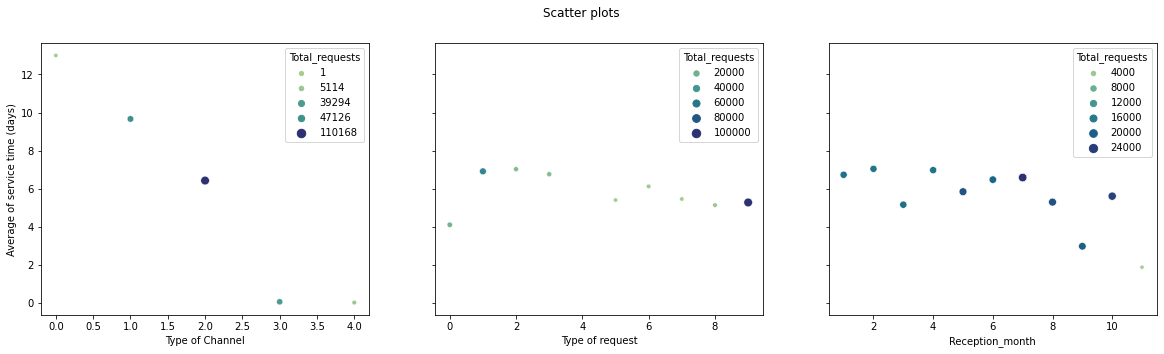

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols = 3, sharey=True, figsize=(20,5))
fig.suptitle('Scatter plots')
sns.scatterplot(data=df_serv_canal, x="Type of Channel", y="Average of service time (days)", hue="Total_requests", size="Total_requests",
 palette ="crest", ax = ax1
)
sns.scatterplot(data=df_serv_soli, x="Type of request", y="Average of service time (days)", hue="Total_requests", size="Total_requests",
 palette ="crest", ax = ax2
)
sns.scatterplot(data=df_serv_mes, x="Reception_month", y="Average of service time (days)", hue="Total_requests", size="Total_requests",
 palette ="crest", ax = ax3
)

<h2>8. Boxplots of service time by different features </h2>

[Text(0, 0.5, 'Service time (days)'), Text(0.5, 0, 'Type of Macroprocess')]

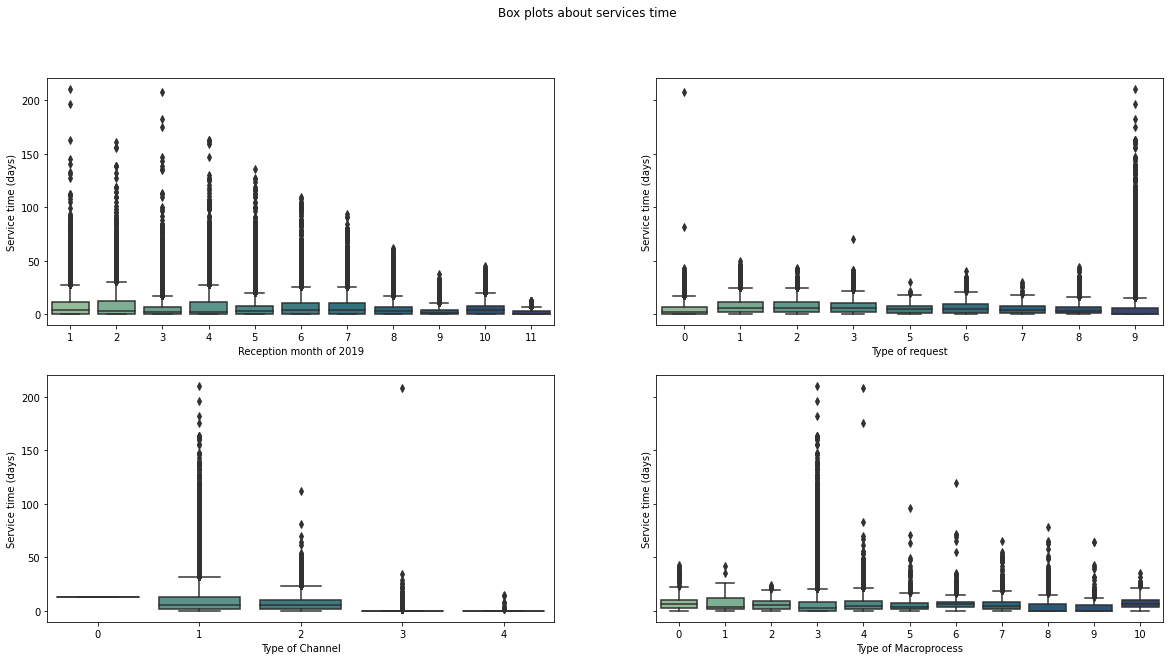

In [ ]:
fig, axs = plt.subplots(ncols = 2, nrows=2,  sharey=True, figsize=(20,10))
fig.suptitle('Box plots about services time')
boxplot1=sns.boxplot(x='Reception_month', y='Service_time_days', data=df_servicio, ax= axs[0,0], palette ="crest")
boxplot1.set(xlabel='Reception month of 2019',ylabel='Service time (days)')

boxplot2=sns.boxplot(x='id_tipo_solicitud', y='Service_time_days', data=df_servicio, ax= axs[0,1], palette ="crest")
boxplot2.set(xlabel='Type of request',ylabel='Service time (days)')

boxplot3=sns.boxplot(x='id_canal', y='Service_time_days', data=df_servicio, ax= axs[1,0], palette ="crest")
boxplot3.set(xlabel='Type of Channel',ylabel='Service time (days)')

boxplot4=sns.boxplot(x='id_macroproceso', y='Service_time_days', data=df_servicio, ax= axs[1,1], palette ="crest")
boxplot4.set(xlabel='Type of Macroprocess',ylabel='Service time (days)')

<h2>9. ANOVA Analysis </h2>

In [ ]:
# Analisis ANOVA del tiempo de servicio por meses
import scipy.stats as stats
# Crear grupo de tiempo de servicio por mes
ene=df_servicio.groupby('Reception_month').get_group(1)['Service_time_days']
feb=df_servicio.groupby('Reception_month').get_group(2)['Service_time_days']
mar=df_servicio.groupby('Reception_month').get_group(3)['Service_time_days']
abr=df_servicio.groupby('Reception_month').get_group(4)['Service_time_days']
may=df_servicio.groupby('Reception_month').get_group(5)['Service_time_days']
jun=df_servicio.groupby('Reception_month').get_group(6)['Service_time_days']
jul=df_servicio.groupby('Reception_month').get_group(7)['Service_time_days']
ago=df_servicio.groupby('Reception_month').get_group(8)['Service_time_days']
sep=df_servicio.groupby('Reception_month').get_group(9)['Service_time_days']
oct=df_servicio.groupby('Reception_month').get_group(10)['Service_time_days']
nov=df_servicio.groupby('Reception_month').get_group(11)['Service_time_days']
#dec=df_servicio.groupby('Reception_month').get_group(12)['Service_time_days']

#Prueba ANOVA para todos los meses
fvalue, pvalue = stats.f_oneway(ene, feb, mar, abr, may, jun, jul, ago, sep, oct, nov)
# Imprime F-value y P-value
print("F-score:",fvalue, "y P-value:", pvalue)

F-score: 407.2045336857181 y P-value: 0.0


In [ ]:
# Analisis ANOVA del tiempo de servicio por canales
import scipy.stats as stats
# Crear grupo de tiempo de servicio por mes
fis=df_servicio.groupby('id_canal').get_group(1)['Service_time_days'] # Canal Fisico
pre=df_servicio.groupby('id_canal').get_group(2)['Service_time_days'] # Canal Virtual
vir=df_servicio.groupby('id_canal').get_group(3)['Service_time_days'] # Canal Presencial
tel=df_servicio.groupby('id_canal').get_group(4)['Service_time_days'] # Canal Telefonico

#Prueba ANOVA para todos los canales
fvalue, pvalue = stats.f_oneway(fis, pre, vir, tel)
# Imprime F-value y P-value
print("F-score:",fvalue, "y P-value:", pvalue)

F-score: 11156.602375612965 y P-value: 0.0


In [ ]:
# Analisis ANOVA del tiempo de servicio por  tipo de solicitud
import scipy.stats as stats
# Crear grupo de tiempo de servicio por tipo de solicitud
t1=df_servicio.groupby('id_tipo_solicitud').get_group(1)['Service_time_days'] # Solicitud tipo 1=Peticiones
t2=df_servicio.groupby('id_tipo_solicitud').get_group(2)['Service_time_days'] # Solicitud tipo 2=Quejas
t3=df_servicio.groupby('id_tipo_solicitud').get_group(3)['Service_time_days'] # Solicitud tipo 3=Reclamos
#t4=df_servicio.groupby('id_tipo_solicitud').get_group(4)['Service_time_days'] # Solicitud tipo 4=Sugerencias
t5=df_servicio.groupby('id_tipo_solicitud').get_group(5)['Service_time_days'] # Solicitud tipo 5=Felicitaciones
t6=df_servicio.groupby('id_tipo_solicitud').get_group(6)['Service_time_days'] # Solicitud tipo 6=Denuncia
t7=df_servicio.groupby('id_tipo_solicitud').get_group(7)['Service_time_days'] # Solicitud tipo 7=Denuncia por corrupcion
t8=df_servicio.groupby('id_tipo_solicitud').get_group(8)['Service_time_days'] # Solicitud tipo 8=Informacion publica
t9=df_servicio.groupby('id_tipo_solicitud').get_group(9)['Service_time_days'] # Solicitud tipo 9=PQSD Verbal
#t10=df_servicio.groupby('id_tipo_solicitud').get_group(10)['Service_time_days'] # Solicitud tipo 10

#Prueba ANOVA para todos los tipos de solicitud
fvalue, pvalue = stats.f_oneway(t1, t2, t3,t5, t6, t7, t8, t9)
# Imprime F-value y P-value
print("F-score:",fvalue, "y P-value:", pvalue)

F-score: 206.5500865092182 y P-value: 7.737795583831314e-307


<h2>10. Alerts </h2>

We can create alerts for the requests that has no the right way to be solved so they are delayed. 

In [ ]:
#Create a column with indicative features for the time of service
# Tim limit: 15 dias habiles aprox a 20 dias calendario
df_servicio['In_Time']= np.where(df_servicio['Service_time_days']<=21, 'Yes', 'No')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
df_servicio.head()

,id_data,fecha_recepcion,id_macroproceso,id_estado_radicado,id_unidad_administrativa,id_anotacion,id_departamento_rnec,id_traslado,id_departamento,id_estado_pqrs,fecha_cierre,dias,dias_laborales,id_fuente_general,id_medio,id_canal,id_municipio,id_nivel,id_oportunidad_cierre,id_oportunidad_tratamiento,cod_iso3,id_sexo,id_tipo_solicitud,id_tipo_identificacion,asunto,Reception_month,Service_time_days,In_Time
0,1,10/01/2019,3,2,2,0,91,0,91,3,14/01/2019,4,3,1,5,2,0,1,1,2,COL,0,1,3,P. - I.D. - T.I. - Agendamiento,1,4,Yes
1,2,22/01/2019,3,2,2,0,91,0,91,3,25/01/2019,3,4,1,5,2,0,1,1,2,COL,0,1,1,P. - I.D. - C.C. - Traslado.,1,3,Yes
2,3,23/01/2019,3,2,2,0,91,481,91,3,25/01/2019,2,3,1,5,2,0,1,1,2,COL,0,9,1,P. - I.D. - C.C. - Cancelaciones.,1,2,Yes
3,4,25/01/2019,4,2,2,0,91,0,91,3,30/01/2019,5,4,1,5,2,0,1,1,2,COL,0,6,1,Q. -Por atencion irrespetuosa del servidor pub...,1,5,Yes
4,5,25/01/2019,4,2,2,0,91,0,91,3,30/01/2019,5,4,1,5,2,0,1,1,2,COL,0,6,1,Q. -Por atencion irrespetuosa del servidor pub...,1,5,Yes


In [ ]:
df_servicio.groupby(['In_Time']).mean()

,id_data,id_macroproceso,id_estado_radicado,id_unidad_administrativa,id_anotacion,id_departamento_rnec,id_traslado,id_departamento,id_estado_pqrs,dias,dias_laborales,id_fuente_general,id_medio,id_canal,id_municipio,id_nivel,id_oportunidad_cierre,id_oportunidad_tratamiento,id_sexo,id_tipo_solicitud,id_tipo_identificacion,Reception_month,Service_time_days
In_Time,,,,,,,,,,,,,,,,,,,,,,,
No,145387.060706,3.212588,1.829412,1.424941,0.018235,117.804941,362.725294,8.121765,2.998235,35.181059,26.103882,3.830000,2.764941,1.263059,33.801529,1.728235,2.188235,1.219882,0.312706,7.386941,1.355294,5.339529,35.181059
Yes,106750.726686,3.271813,1.010202,3.215628,0.001247,85.493269,109.978199,13.557766,2.999063,4.481002,4.181509,2.231358,5.338675,2.044813,54.948489,1.488429,1.589401,2.012541,0.652417,5.253868,1.346822,5.906435,4.481002


In [ ]:
df_intime=df_servicio.groupby(['In_Time']).agg({'In_Time':'count'}).rename(columns={'In_Time':'Total of Requests'})
df_intime['Proportion']=((df_intime['Total of Requests']/total_rows)*100).round(2)
df_intime

,Total of Requests,Proportion
In_Time,,
No,8500,4.21
Yes,193203,95.79


Text(0.5, 1.0, 'In Time Request')

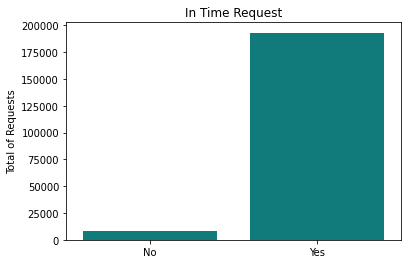

In [ ]:
ax=sns.barplot(x=['No','Yes'],y=df_intime['Total of Requests'], color='darkcyan')
ax.set_title('In Time Request')